# Deep Neural Network with many hidden layers for forex

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from utils.dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward
import copy
import scipy
from PIL import Image
from scipy import ndimage
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
import sklearn.datasets
import sklearn.linear_model


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
df = pd.read_csv("./datasets/5_min_EUR_USD_2019_to_2023_mid_prices.csv")
df

,time,EUR_USD
0,2018-08-22 02:40:00+00:00,1.15758
1,2018-08-22 02:45:00+00:00,1.15750
2,2018-08-22 02:50:00+00:00,1.15726
3,2018-08-22 02:55:00+00:00,1.15746
4,2018-08-22 03:00:00+00:00,1.15746
...,...,...
372104,2023-08-22 08:15:00+00:00,1.09182
372105,2023-08-22 08:20:00+00:00,1.09184
372106,2023-08-22 08:25:00+00:00,1.09183
372107,2023-08-22 08:30:00+00:00,1.09174


In [3]:
symbol = 'EUR_USD'
features_col_names = ["price", 'returns', "dir"]
window = 50 # rolling window 
df["returns"] = np.log(df[symbol] / df[symbol].shift())
# if its positive we assign it [1] else negative [0]
# Since this is a logistic regression Binary classification model its best to predict either 0 or 1 we cant make it 
# make it predict -1 if the price went down
df['dir'] = np.where(df['returns'] > 0, 1, 0)
df.dropna(inplace = True)

In [4]:
def create_sequences(df, seq_length):
    X, y = [], []
    for i in range(0, len(df)-seq_length, seq_length):
        X.append(df[df.columns[1]].iloc[i:i+seq_length])
        y.append(df[df.columns[3]].iloc[i+seq_length - 1])
    return np.array(X), np.array(y)

In [5]:
X, y = create_sequences(df, 300)

In [6]:
X.shape, y.shape

((1240, 300), (1240,))

In [7]:
# Standarize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train.shape, X_test.shape

((992, 300), (248, 300))

In [10]:
y_train.shape, y_test.shape

((992,), (248,))

In [11]:
train_set_x = X_train.reshape(X_train.shape[0], -1).T
test_set_x = X_test.reshape(X_test.shape[0], -1).T

In [12]:
train_set_x.shape, test_set_x.shape

((300, 992), (300, 248))

In [14]:
train_set_y = y_train.reshape(1, -1)
test_set_y = y_test.reshape(1, -1)
train_set_y.shape, test_set_y.shape

((1, 992), (1, 248))

In [15]:
print(f"""
train_set_x shape: {train_set_x.shape}
test_set_x shape: {test_set_x.shape}

train_set_y shape: {train_set_y.shape}
test_set_y shape: {test_set_y.shape}
""")


train_set_x shape: (300, 992)
test_set_x shape: (300, 248)

train_set_y shape: (1, 992)
test_set_y shape: (1, 248)



# Model

In [29]:
from utils.dnn_utils import *

In [30]:
### CONSTANTS DEFINING THE MODEL ####
n_x = train_set_x.shape[0]     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [31]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

Cost after iteration 0: 0.6931130777110766
Cost after iteration 100: 0.6931029306659298
Cost after iteration 200: 0.6930934217015096
Cost after iteration 300: 0.6930842371439372
Cost after iteration 400: 0.6930751119303495
Cost after iteration 500: 0.6930660152947213
Cost after iteration 600: 0.6930569119951866
Cost after iteration 700: 0.6930478057687249
Cost after iteration 800: 0.6930387008651787
Cost after iteration 900: 0.6930296354240372
Cost after iteration 1000: 0.6930206900221592
Cost after iteration 1100: 0.6930119395861444
Cost after iteration 1200: 0.6930034440330266
Cost after iteration 1300: 0.6929952841068188
Cost after iteration 1400: 0.6929875444539852
Cost after iteration 1500: 0.6929802836895042
Cost after iteration 1600: 0.692973546494508
Cost after iteration 1700: 0.6929673603037468
Cost after iteration 1800: 0.6929617365217664
Cost after iteration 1900: 0.6929566748721204
Cost after iteration 2000: 0.6929521650072121
Cost after iteration 2100: 0.6929481788771935
C

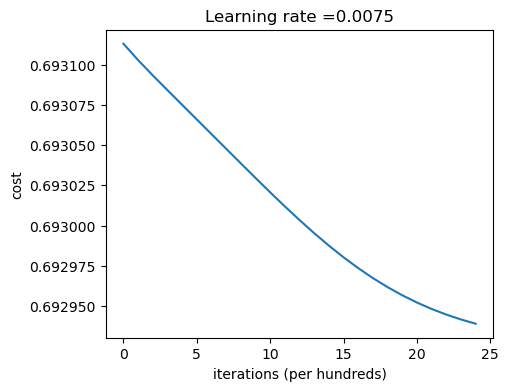

In [32]:
parameters, costs = two_layer_model(train_set_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

In [33]:
predictions_train = predict(train_set_x, train_set_y, parameters)

Accuracy: 0.5141129032258065


In [34]:
predictions_test = predict(train_set_x, train_set_y, parameters)

Accuracy: 0.5141129032258065


### Multi-layer- DNN

In [39]:
layers_dims = [train_set_x.shape[0], 20, 7, 5, 1] #  4-layer model

In [40]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [41]:
parameters, costs = L_layer_model(train_set_x, train_set_y, layers_dims, num_iterations = 1, print_cost = False)
print("Cost after first iteration: " + str(costs[0]))

Cost after iteration 0: 0.7573199440215989
Cost after first iteration: 0.7573199440215989


In [42]:
parameters, costs = L_layer_model(train_set_x, train_set_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.7573199440215989
Cost after iteration 100: 0.694059403820642
Cost after iteration 200: 0.6930365314553418
Cost after iteration 300: 0.6929181108878769
Cost after iteration 400: 0.6928332043515008
Cost after iteration 500: 0.6928118062500032
Cost after iteration 600: 0.6927867437105351
Cost after iteration 700: 0.692768497632822
Cost after iteration 800: 0.6927440073223321
Cost after iteration 900: 0.6927308820168816
Cost after iteration 1000: 0.6927177774873495
Cost after iteration 1100: 0.69270772239456
Cost after iteration 1200: 0.692695337071506
Cost after iteration 1300: 0.692683767335179
Cost after iteration 1400: 0.6926711236120451
Cost after iteration 1500: 0.6926596612928632
Cost after iteration 1600: 0.6926494833300529
Cost after iteration 1700: 0.6926402287942853
Cost after iteration 1800: 0.6926310777235293
Cost after iteration 1900: 0.6926220724981139
Cost after iteration 2000: 0.6926119431701436
Cost after iteration 2100: 0.6926032658110705
Cost a

In [45]:
pred_train = predict(train_set_x, train_set_y, parameters)

Accuracy: 0.5171370967741935


In [44]:
pred_test = predict(test_set_x, test_set_y, parameters)

Accuracy: 0.5362903225806451
